In [1]:
import os
from glob import glob
from PIL import Image

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
# 약 3,700장의 꽃 사진 데이터세트를 사용합니다.
# 아래 데이터 가져오기 그냥 사용합니다.

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 7s 0us/step


In [3]:
# 하이터 파라미터 정의
input_shape = (224, 224, 3)
batch_size = 32
num_classes = 5

In [4]:
# 이미지 패스 지정
img_path ='/root/.keras/datasets/flower_photos/'

In [5]:
# image_dataset_from_directory 함수 활용하여
# 이미지 폴더 밑의 이미지들에 대해 원핫인코딩된 labeling수행, 이미지 배치, 셔플 수행

# Train Dataset 만들기
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=img_path,
                                             label_mode="categorical",   # binary , categorical
                                             batch_size=batch_size,
                                             image_size=(224, 224),      # 사이즈 확인
                                             seed=42,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

# Test Dataset 만들기
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=img_path,
                                             label_mode="categorical",   # binary , categorical
                                             batch_size=batch_size,
                                             image_size=(224, 224),      # 사이즈 확인
                                             seed=42,
                                             validation_split=0.2,
                                             subset="validation"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
# 40,000건 중에서 32,000건 Train 사용. test용으로 8,000건 사용
len(train_ds) * 32 , len(test_ds) * 32

(2944, 736)

In [7]:
batch_img, batch_label = next(iter(train_ds))
batch_img.shape, batch_label.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 5]))

In [9]:
# 사전 훈련된 모델 MobileNetV2에서 기본 모델을 생성합니다.
# 아래와 같은 형식을 MobileNetV2 Transfer Learning 사용하며 됩니다.

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
# MobileNet V2 베이스 모델 고정하기
base_model.trainable = False

In [11]:
import tensorflow as tf
from tensorflow import keras 

In [12]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(224, 
                                                              224,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [15]:
# 모델 구축 : 이미지 픽셀값 조정 수행하기(Rescaling) --> 성능 더 잘 나옴.

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./255, offset=-1)(x)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 3차원(7, 7, 1280) --> 1차원(1280)으로 줄이기 : GlobalAveragePooling2D
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 6405  

In [18]:
# Model compile
model.compile(
        optimizer=tf.keras.optimizers.Adam(0.05),  # Optimization
        #optimizer='adam',
              loss='categorical_crossentropy',  # Loss Function
              metrics=['accuracy'])  # Metrics / Accuracy

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# ModelCheckpoint
checkpoint_path = "my_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [ ]:
# image_dataset_from_directory 이용하여 데이터 만들었을때 아래와 같이 학습 진행
# num_epochs = 10

# 모델 학습(fit)
history = model.fit(
    train_ds,
    validation_data=(test_ds),
    epochs=5,
    callbacks=[es, checkpoint]
)

Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 2.9972 - accuracy: 0.7497
Epoch 1: val_loss improved from inf to 2.23562, saving model to my_checkpoint.ckpt
INFO:tensorflow:Assets written to: my_checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: my_checkpoint.ckpt/assets


92/92 [==============================] - 159s 2s/step - loss: 2.9972 - accuracy: 0.7497 - val_loss: 2.2356 - val_accuracy: 0.8052
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 1.6423 - accuracy: 0.8437
Epoch 2: val_loss did not improve from 2.23562
92/92 [==============================] - 138s 1s/step - loss: 1.6423 - accuracy: 0.8437 - val_loss: 2.9178 - val_accuracy: 0.7629
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 1.4631 - accuracy: 0.8488

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

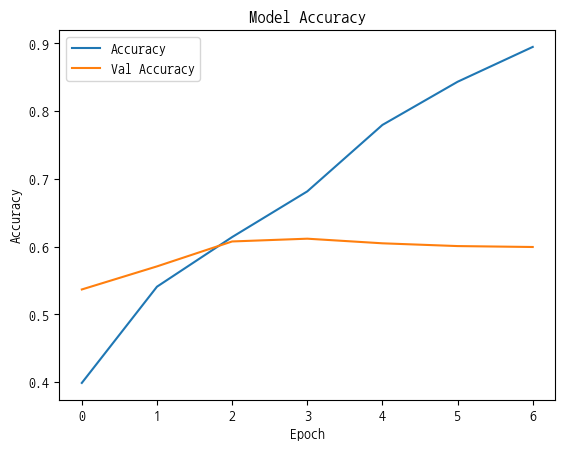

In [33]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [34]:
# test_generator 샘플 데이터 가져오기
# 배치 사이즈 32 확인

batch_img, batch_label = next(iter(test_ds))
print(batch_img.shape)
print(batch_label.shape)

(32, 224, 224, 3)
(32, 5)


In [35]:
# 이미지 rescale 되어 있는 상태
batch_img[0][0][:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[182.5     , 207.21428 , 225.78572 ],
       [155.85715 , 189.42857 , 202.      ],
       [ 81.14285 ,  96.92856 ,  75.928566],
       [ 59.5     ,  42.5     ,  42.      ],
       [ 46.21428 ,  44.714287,  47.071426],
       [144.07144 , 165.78572 , 180.07144 ],
       [181.57143 , 202.2143  , 227.7143  ],
       [173.35715 , 192.2143  , 212.85715 ],
       [178.7857  , 204.      , 229.57143 ],
       [167.7143  , 195.28572 , 218.5     ]], dtype=float32)>

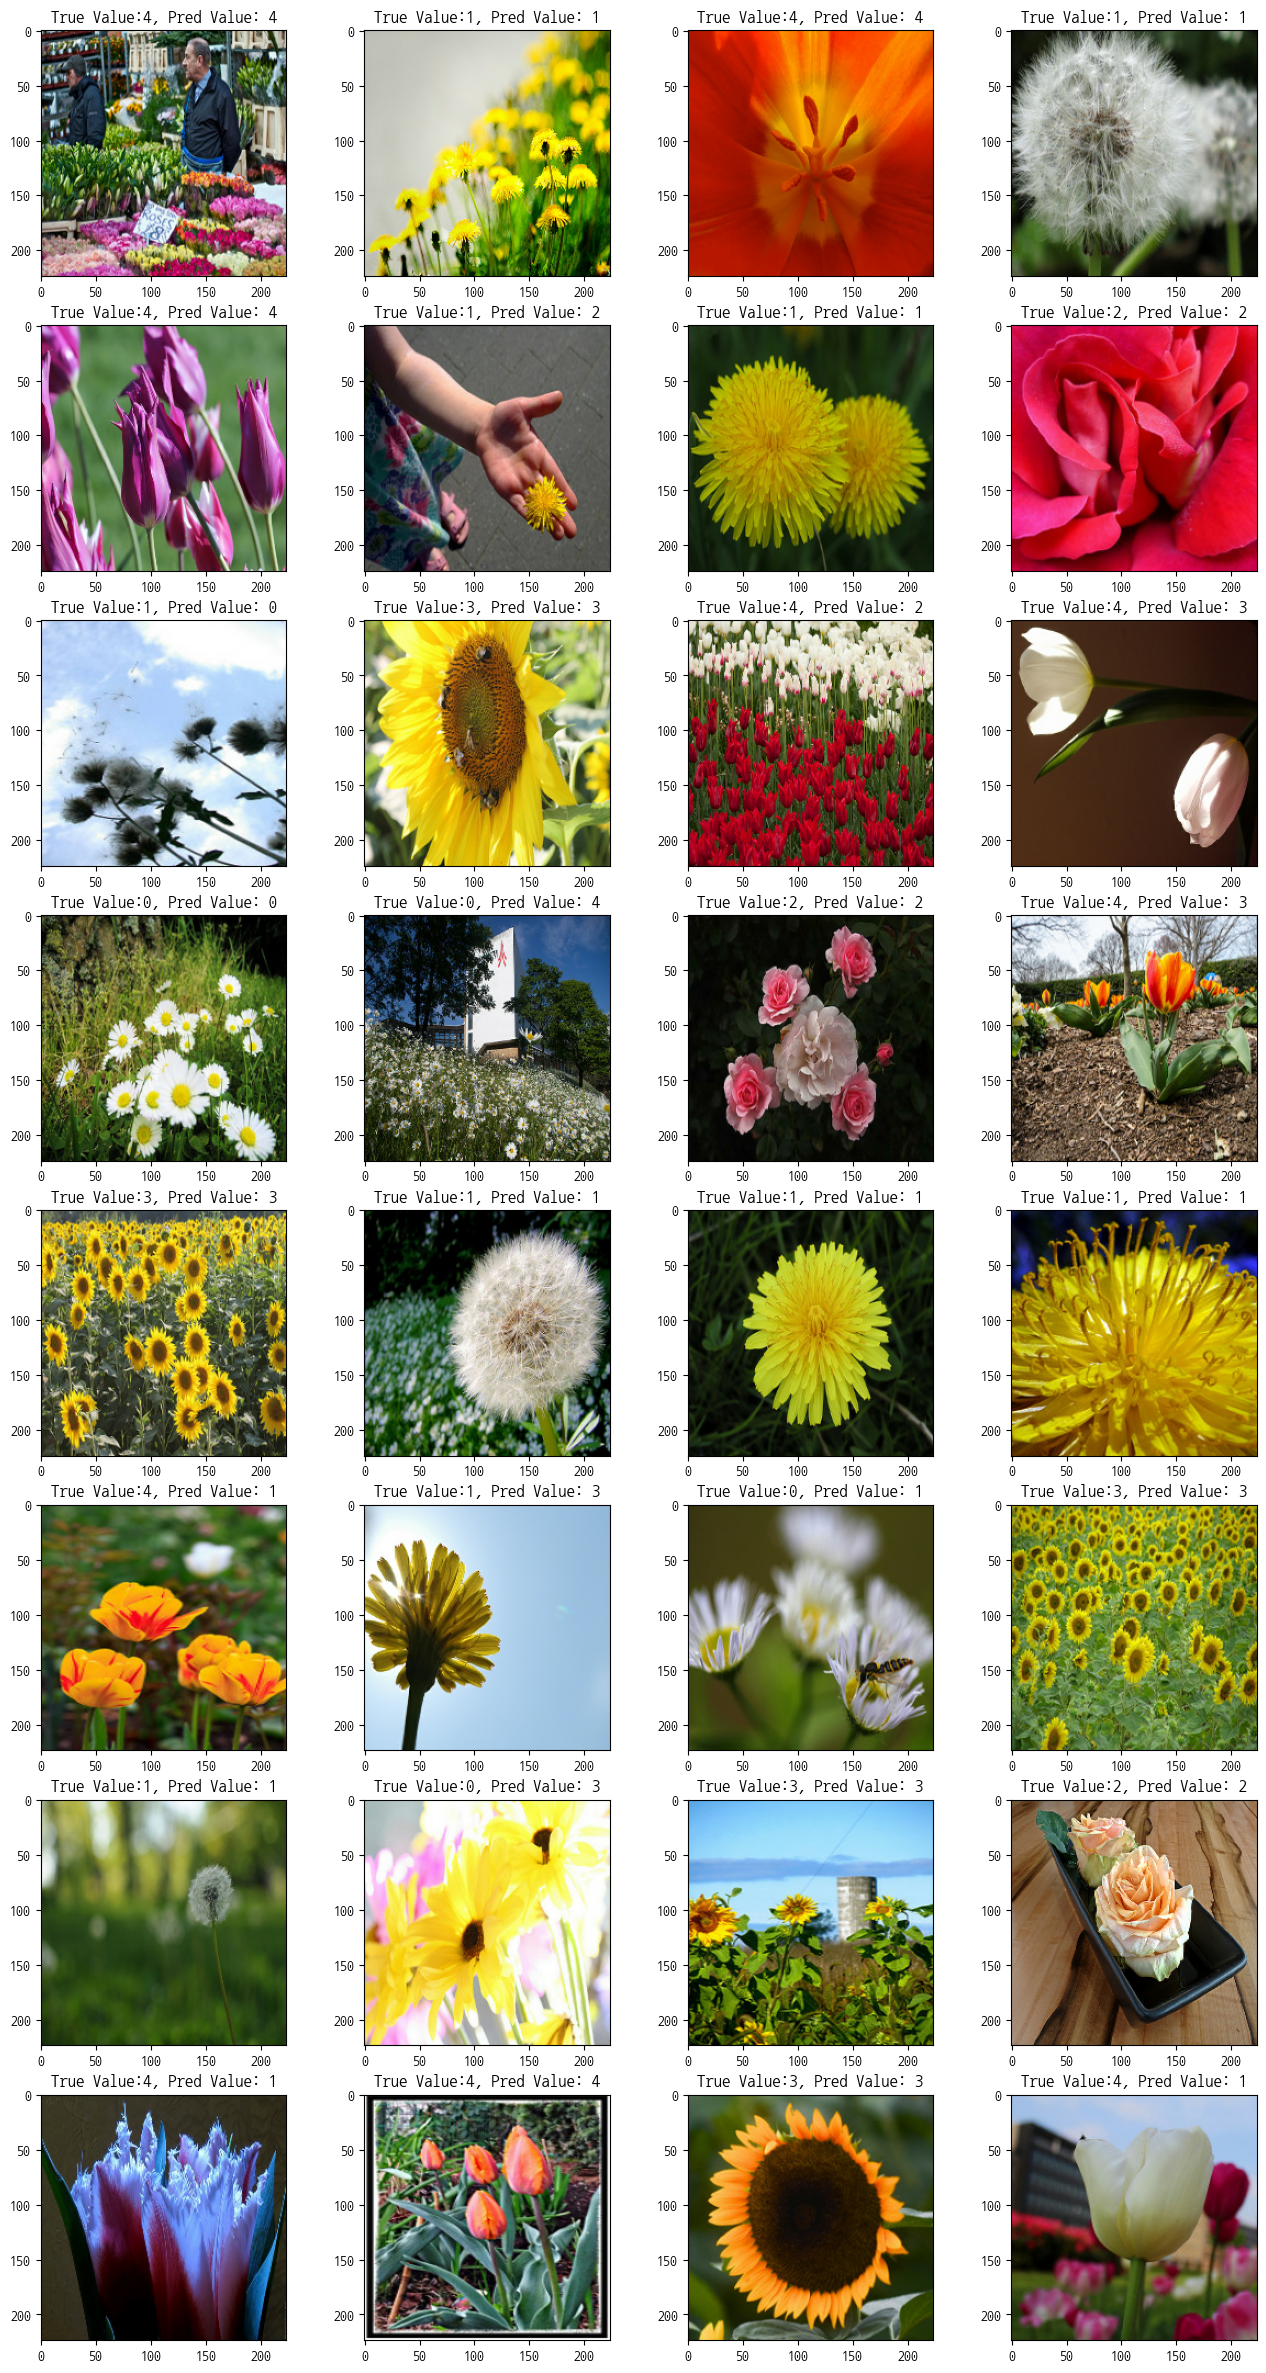

In [36]:
# 100% 성능 보여줌

i = 1
plt.figure(figsize=(16, 30))
for img, label in list(zip(batch_img, batch_label)):
    pred = model.predict(img.numpy().reshape(-1, 224,224,3), verbose=0)
    pred_t = np.argmax(pred)
    plt.subplot(8, 4, i)
    plt.title(f'True Value:{np.argmax(label)}, Pred Value: {pred_t}')
    plt.imshow(img/255)  # 이미지 픽셀값들이 실수형이므로 0~1 사이로 변경해야 에러 안남
    i = i + 1